# Homework

In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).

Or you can do it with wget:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
```
In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [43]:
path = "data/homework/course_lead_scoring_m4.csv"
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [44]:
!wget -O $path $data

--2025-10-20 21:57:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘data/homework/course_lead_scoring_m4.csv’

data/homework/cours 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

2025-10-20 21:57:01 (7.12 MB/s) - ‘data/homework/course_lead_scoring_m4.csv’ saved [80876/80876]



In [45]:
df = pd.read_csv(path)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [47]:
numerical = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'converted']
categorical = list(df.select_dtypes(include=['object', 'bool']).columns)
numerical, categorical

(['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'],
 ['lead_source', 'industry', 'employment_status', 'location'])

In [48]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [49]:
for cat in categorical:
    print(cat)
    print("Nulos:")
    print(df[cat].isna().sum())
    df[cat] = df[cat].fillna('NA')
    print("Nulos despues de fillna:")
    print(df[cat].isna().sum())
    print()

lead_source
Nulos:
128
Nulos despues de fillna:
0

industry
Nulos:
134
Nulos despues de fillna:
0

employment_status
Nulos:
100
Nulos despues de fillna:
0

location
Nulos:
63
Nulos despues de fillna:
0



In [50]:
for num in numerical:
    print(num)
    print("Nulos:")
    print(df[num].isna().sum())
    df[num] = df[num].fillna(0.0)
    print("Nulos despues de fillna:")
    print(df[num].isna().sum())
    print()

number_of_courses_viewed
Nulos:
0
Nulos despues de fillna:
0

annual_income
Nulos:
181
Nulos despues de fillna:
0

interaction_count
Nulos:
0
Nulos despues de fillna:
0

lead_score
Nulos:
0
Nulos despues de fillna:
0



In [51]:
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [52]:
seed = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [53]:
# Resetting index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [54]:
# Target values
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [55]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [56]:
len(y_train)

876

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [57]:
variables_to_check = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]

auc_scores = {}

print("--- Calculating Feature AUC ---")

for col in variables_to_check:
    auc = roc_auc_score(y_train, df_train[col])
    
    if auc < 0.5:
        auc = 1 - auc
        print(f"Variable: {col}, Final AUC: {auc:.4f} (Inverted)")
    else:
        print(f"Variable: {col}, Final AUC: {auc:.4f}")
    
    auc_scores[col] = auc

print("---------------------------------")

if auc_scores:
    best_variable = max(auc_scores, key=auc_scores.get)
    highest_auc = auc_scores[best_variable]

    print(f"The variable with the highest AUC is: {best_variable} (AUC = {highest_auc:.4f})")
else:
    print("No scores were calculated. Please check your variable names and data.")

--- Calculating Feature AUC ---
Variable: lead_score, Final AUC: 0.6145
Variable: number_of_courses_viewed, Final AUC: 0.7636
Variable: interaction_count, Final AUC: 0.7383
Variable: annual_income, Final AUC: 0.5520
---------------------------------
The variable with the highest AUC is: number_of_courses_viewed (AUC = 0.7636)


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [58]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)

print(f"\nAUC on validation dataset: {auc:.3f}")


AUC on validation dataset: 0.817


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

--- Precision-Recall Intersection ---
Threshold where curves are closest: 0.640
Precision at this threshold: 0.779
Recall at this threshold: 0.784
-------------------------------------


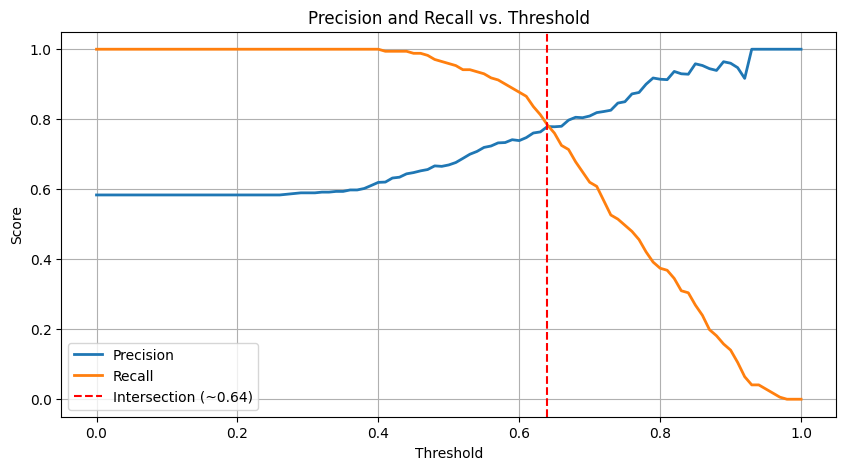

In [59]:
precision_scores = []
recall_scores = []
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    # Calculate Precision (p) and Recall (r)
    # Handle division by zero
    if (tp + fp) == 0:
        p = 1.0  # Convention: precision is 1.0 if no positive preds
    else:
        p = tp / (tp + fp)
    
    if (tp + fn) == 0:
        r = 0.0  # Convention: recall is 0.0 if no actual positives
    else:
        r = tp / (tp + fn)
    precision_scores.append(p)
    recall_scores.append(r)
   

prec_arr = np.array(precision_scores)
rec_arr = np.array(recall_scores)


diffs = np.abs(prec_arr[1:-1] - rec_arr[1:-1])

best_idx = np.argmin(diffs) + 1

best_threshold = thresholds[best_idx]
best_precision = prec_arr[best_idx]
best_recall = rec_arr[best_idx]

print(f"--- Precision-Recall Intersection ---")
print(f"Threshold where curves are closest: {best_threshold:.3f}")
print(f"Precision at this threshold: {best_precision:.3f}")
print(f"Recall at this threshold: {best_recall:.3f}")
print("-------------------------------------")

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision_scores, label='Precision', lw=2)
plt.plot(thresholds, recall_scores, label='Recall', lw=2)

plt.axvline(x=best_threshold, color='red', linestyle='--', 
            label=f'Intersection (~{best_threshold:.2f})')

plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74


--- Maximal F1 Score ---
Threshold where F1 is maximal: 0.570
Max F1 score: 0.812
Precision at this threshold: 0.732
Recall at this threshold: 0.912
--------------------------


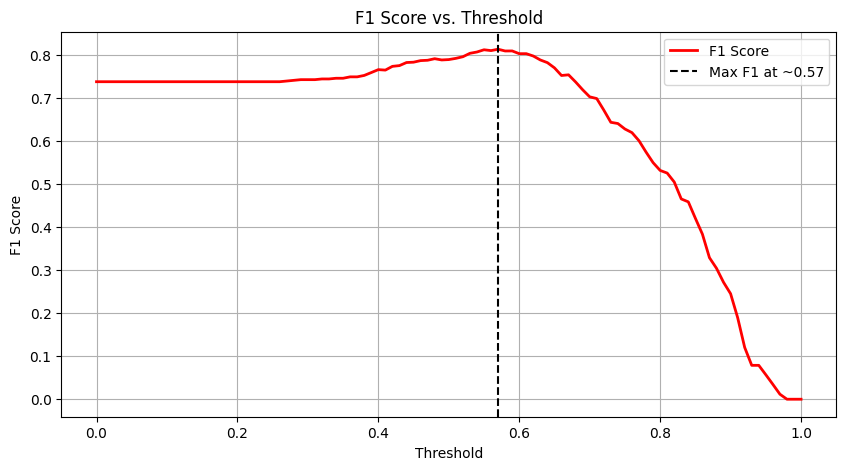

In [60]:
f1_scores = 2 * (prec_arr * rec_arr) / (prec_arr + rec_arr)

best_idx = np.argmax(f1_scores)

best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = prec_arr[best_idx]
best_recall = rec_arr[best_idx]

print(f"--- Maximal F1 Score ---")
print(f"Threshold where F1 is maximal: {best_threshold:.3f}")
print(f"Max F1 score: {best_f1:.3f}")
print(f"Precision at this threshold: {best_precision:.3f}")
print(f"Recall at this threshold: {best_recall:.3f}")
print("--------------------------")

plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1 Score', lw=2, color='red')

plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.axvline(x=best_threshold, color='black', linestyle='--', 
            label=f'Max F1 at ~{best_threshold:.2f}')
plt.legend()
plt.grid(True)
plt.show()

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [81]:
def train(df, y_train, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return dv, model

In [82]:
dv, model = train(df_train, y_train, C=1.0)

In [83]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [84]:
y_pred = predict(df_val, dv, model)

In [85]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


In [86]:

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    score = roc_auc_score(y_val, y_pred)
    print(f"score: {score:.3f}")
    scores.append(score)


score: 0.806
score: 0.871
score: 0.775
score: 0.802
score: 0.856


In [92]:
np.mean(scores), np.std(scores)

(np.float64(0.8221089148573075), np.float64(0.03580711942905165))

In [88]:
len(train_idx), len(val_idx), len(df_full_train)

(936, 233, 1169)

In [89]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [90]:
dv, model = train(df_full_train, df_full_train.converted.values, C=1.0)
y_pred = predict(df_val, dv, model)

auc = roc_auc_score(y_val, y_pred)
auc

0.8587679925708094

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [91]:

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        score = roc_auc_score(y_val, y_pred)
        scores.append(score)

    print(f"C={C}: {np.mean(scores):.3f} +- {np.std(scores):.3f}")

C=1e-06: 0.560 +- 0.024
C=0.001: 0.867 +- 0.029
C=1: 0.822 +- 0.036
